In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [31]:
# read in csv as dataframe
county_df = pd.read_csv('https://mydataclassdb-bucket.s3.amazonaws.com/covid_and_politics_db.csv')
county_df.head()

,county,state,county_state,lat,long,totalpop,total_votes20,votes20_donald_trump,votes20_joe_biden,percentage20_donald_trump,...,age_55to64,age_65to74,age_75to84,age_84plus,evangelicals,protestant,catholic,orthodox,muslim,other
0,Kay,OK,"Kay, OK",36.817997,-97.144214,45173,17249,12834,4040,0.744,...,5694,4632,2724,1183,0,0,0,0,0,0
1,Abbeville,SC,"Abbeville, SC",34.223334,-82.461707,24788,12433,8215,4101,0.661,...,3584,3150,1602,591,0,0,0,0,0,0
2,Acadia,LA,"Acadia, LA",30.295065,-92.414197,62607,28425,22596,5443,0.795,...,0,0,0,0,0,0,0,0,0,0
3,Accomack,VA,"Accomack, VA",37.767072,-75.632346,32840,16938,9172,7578,0.542,...,5270,4451,2301,886,0,0,0,0,0,0
4,Ada,ID,"Ada, ID",43.452658,-116.241552,435117,259389,130699,120539,0.504,...,56615,42027,18576,7189,0,0,0,0,0,0


In [32]:
# get a list of columns
county_df.columns

Index(['county', 'state', 'county_state', 'lat', 'long', 'totalpop',
       'total_votes20', 'votes20_donald_trump', 'votes20_joe_biden',
       'percentage20_donald_trump', 'percentage20_joe_biden', 'cases',
       'deaths', 'men', 'women', 'hispanic', 'white', 'black', 'native',
       'asian', 'pacific', 'income', 'incomepercap', 'poverty', 'professional',
       'service', 'office', 'construction', 'production', 'drive', 'carpool',
       'transit', 'walk', 'othertransp', 'workathome', 'meancommute',
       'employed', 'privatework', 'publicwork', 'selfemployed', 'familywork',
       'unemployment', 'cases_per_capita_100k', 'deaths_per_capita_100k',
       'pop_per_sq_mile_2010', 'age_oto4', 'age_5to14', 'age_15to24',
       'age_25to34', 'age_35to44', 'age_45to54', 'age_55to64', 'age_65to74',
       'age_75to84', 'age_84plus', 'evangelicals', 'protestant', 'catholic',
       'orthodox', 'muslim', 'other'],
      dtype='object')

In [33]:
# create feature
X = county_df['percentage20_donald_trump'].values.reshape(-1,1)
X[:5]

array([[0.744],
       [0.661],
       [0.795],
       [0.542],
       [0.504]])

In [34]:
# normalize cases by dividing cases per county with total population of county
county_df['normalized_cases'] = county_df['cases']/county_df['totalpop']
county_df['normalized_cases']

0       0.020366
1       0.032475
2       0.050825
3       0.037363
4       0.040106
          ...   
3043    0.037071
3044    0.031420
3045    0.050655
3046    0.041854
3047    0.024638
Name: normalized_cases, Length: 3048, dtype: float64

In [35]:
# create target with normalized cases
y = county_df['normalized_cases']
y[:5]

0    0.020366
1    0.032475
2    0.050825
3    0.037363
4    0.040106
Name: normalized_cases, dtype: float64

In [36]:
# instantiate model
model = sm.OLS(y, X)

# fit model
results = model.fit()

# print summary statistics
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:       normalized_cases   R-squared (uncentered):                   0.681
Model:                            OLS   Adj. R-squared (uncentered):              0.681
Method:                 Least Squares   F-statistic:                              6517.
Date:                Tue, 16 Mar 2021   Prob (F-statistic):                        0.00
Time:                        20:55:34   Log-Likelihood:                          7763.5
No. Observations:                3048   AIC:                                 -1.552e+04
Df Residuals:                    3047   BIC:                                 -1.552e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [37]:
# make a df with actual values and predictions
pred_df1 = pd.DataFrame({'Real Values': y, 'Predicted Values': results.predict()})

# create a column with the differences between the real and predicted values
pred_df1['Difference'] = pred_df1['Real Values'] - pred_df1['Predicted Values']

# calculate the mean of the difference
mean1 = pred_df1['Difference'].mean()

# show the mean of the difference
print(f'Mean of differences: {mean1}')

# show df
pred_df1.head()

Mean of differences: 0.0016474944565770774


,Real Values,Predicted Values,Difference
0,0.020366,0.030552,-0.010186
1,0.032475,0.027144,0.005332
2,0.050825,0.032646,0.018179
3,0.037363,0.022257,0.015106
4,0.040106,0.020697,0.019410


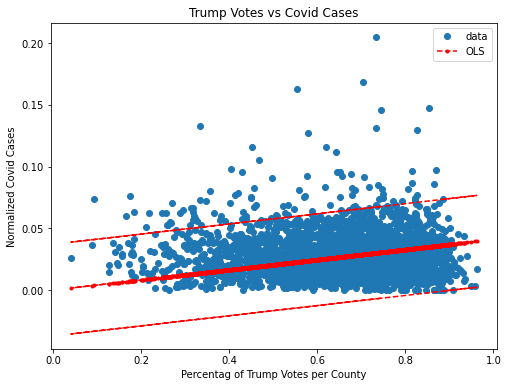

In [39]:
# Draw a plot to compare the true relationship to OLS predictions with confidence intervals

prstd, iv_l, iv_u = wls_prediction_std(results)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X, y, 'o', label="data")
ax.plot(X, results.fittedvalues, 'r--.', label="OLS")
ax.plot(X, iv_u, 'r--')
ax.plot(X, iv_l, 'r--')
ax.set_ylabel('Normalized Covid Cases')
ax.set_xlabel('Percentag of Trump Votes per County')
ax.set_title('Trump Votes vs Covid Cases')
ax.legend(loc='best');

In [40]:
# create feature for second model
X2 = county_df['percentage20_joe_biden'].values.reshape(-1,1)
X2[:5]

array([[0.234],
       [0.33 ],
       [0.191],
       [0.447],
       [0.465]])

In [41]:
# create target for second model
y2 = county_df.normalized_cases
y2[:5]

0    0.020366
1    0.032475
2    0.050825
3    0.037363
4    0.040106
Name: normalized_cases, dtype: float64

In [42]:
# instantiate second model
model2 = sm.OLS(y2, X2)

#fit second model
results2 = model2.fit()

# print summary statistics for second model
print(results2.summary())

                                 OLS Regression Results                                
Dep. Variable:       normalized_cases   R-squared (uncentered):                   0.603
Model:                            OLS   Adj. R-squared (uncentered):              0.603
Method:                 Least Squares   F-statistic:                              4626.
Date:                Tue, 16 Mar 2021   Prob (F-statistic):                        0.00
Time:                        20:55:42   Log-Likelihood:                          7427.7
No. Observations:                3048   AIC:                                 -1.485e+04
Df Residuals:                    3047   BIC:                                 -1.485e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [43]:
# make a df with actual values and predictions
pred_df2 = pd.DataFrame({'Real Values': y2, 'Predicted Values': results2.predict()})

# create a column with the differences between the real and predicted values
pred_df2['Difference'] = pred_df2['Real Values'] - pred_df2['Predicted Values']

# calculate the mean of the difference
mean2 = pred_df2['Difference'].mean()

# show the mean of the difference
print(f'Mean of differences: {mean2}')

# show df
pred_df2.head()

Mean of differences: 0.005068809230883486


,Real Values,Predicted Values,Difference
0,0.020366,0.016876,0.003490
1,0.032475,0.023799,0.008676
2,0.050825,0.013775,0.037050
3,0.037363,0.032237,0.005126
4,0.040106,0.033536,0.006571


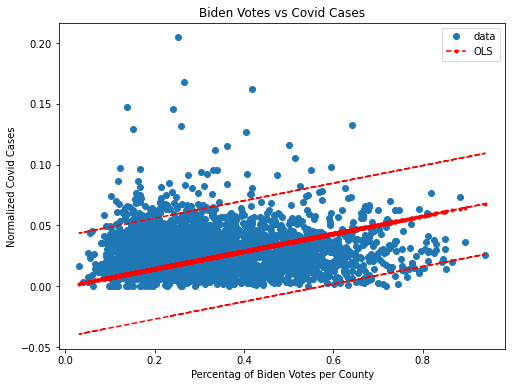

In [44]:
# Draw a plot to compare the true relationship to OLS predictions with confidence intervals
# for second model
prstd, iv_l, iv_u = wls_prediction_std(results2)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X2, y2, 'o', label="data")
ax.plot(X2, results2.fittedvalues, 'r--.', label="OLS")
ax.plot(X2, iv_u, 'r--')
ax.plot(X2, iv_l, 'r--')
ax.set_ylabel('Normalized Covid Cases')
ax.set_xlabel('Percentag of Biden Votes per County')
ax.set_title('Biden Votes vs Covid Cases')
ax.legend(loc='best');

In [45]:
# normalize the total votes for the 2020 election per county by dividing the total votes
# by the total county population

county_df['normalized_totalvotes'] = county_df['total_votes20']/county_df['totalpop']
county_df['normalized_totalvotes'].head()

0    0.381843
1    0.501573
2    0.454023
3    0.515773
4    0.596136
Name: normalized_totalvotes, dtype: float64

In [46]:
# create feature for the third model
X3 = county_df['normalized_totalvotes'].values.reshape(-1,1)
X3[:5]

array([[0.38184314],
       [0.50157334],
       [0.45402271],
       [0.51577345],
       [0.59613621]])

In [47]:
# create target for the third model
y3 = county_df.normalized_cases
y3[:5]

0    0.020366
1    0.032475
2    0.050825
3    0.037363
4    0.040106
Name: normalized_cases, dtype: float64

In [48]:
# instantiate third model
model3 = sm.OLS(y3, X3)

# fit third model
results3 = model3.fit()

# print summary statistics for third model
print(results3.summary())

                                 OLS Regression Results                                
Dep. Variable:       normalized_cases   R-squared (uncentered):                   0.652
Model:                            OLS   Adj. R-squared (uncentered):              0.652
Method:                 Least Squares   F-statistic:                              5708.
Date:                Tue, 16 Mar 2021   Prob (F-statistic):                        0.00
Time:                        20:55:46   Log-Likelihood:                          7628.7
No. Observations:                3048   AIC:                                 -1.526e+04
Df Residuals:                    3047   BIC:                                 -1.525e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [49]:
# make a df with actual values and predictions
pred_df3 = pd.DataFrame({'Real Values': y3, 'Predicted Values': results3.predict()})

# create a column with the differences between the real and predicted values
pred_df3['Difference'] = pred_df3['Real Values'] - pred_df3['Predicted Values']

# calculate the mean of the difference
mean3 = pred_df3['Difference'].mean()

# show the mean of the difference
print(f'Mean of differences: {mean3}')

# show df
pred_df3.head()

Mean of differences: 0.0021889205558033253


,Real Values,Predicted Values,Difference
0,0.020366,0.020796,-0.000430
1,0.032475,0.027317,0.005158
2,0.050825,0.024727,0.026098
3,0.037363,0.028091,0.009272
4,0.040106,0.032467,0.007639


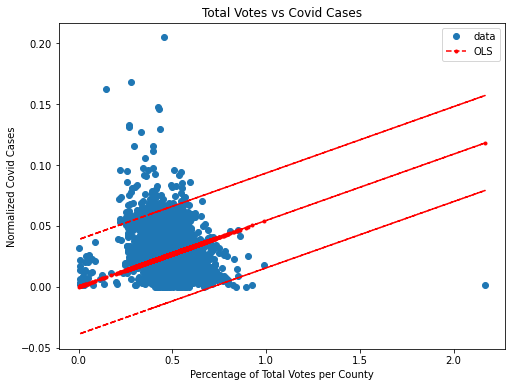

In [50]:
# Draw a plot to compare the true relationship to OLS predictions with confidence intervals
# for third model
prstd, iv_l, iv_u = wls_prediction_std(results3)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X3, y3, 'o', label="data")
ax.plot(X3, results3.fittedvalues, 'r--.', label="OLS")
ax.plot(X3, iv_u, 'r--')
ax.plot(X3, iv_l, 'r--')
ax.set_ylabel('Normalized Covid Cases')
ax.set_xlabel('Percentage of Total Votes per County')
ax.set_title('Total Votes vs Covid Cases')
ax.legend(loc='best');

In [51]:
# define variables to compare predictions for political categories
trump_votes_meandiff = mean1
biden_votes_meandiff = mean2
total_votes_meandiff = mean3

# define variables to compare model fit (Rsquared) for political categories
trump_votes_R2 = results.rsquared
biden_votes_R2 = results2.rsquared
total_votes_R2 = results3.rsquared

In [52]:
index=[0]
voting_comparison_df = pd.DataFrame({'Trump Votes meandiff': trump_votes_meandiff,'Biden Votes meandiff': biden_votes_meandiff,
                                     'Total Votes meandiff': total_votes_meandiff,'Trump Votes R2': trump_votes_R2,
                                     'Biden Votes R2': biden_votes_R2,'Total Votes R2': total_votes_R2},
                                   index=index)
voting_comparison_df

,Trump Votes meandiff,Biden Votes meandiff,Total Votes meandiff,Trump Votes R2,Biden Votes R2,Total Votes R2
0,0.001647,0.005069,0.002189,0.681414,0.60288,0.651954
